# LSST DM Stack Image Quality Walkthrough

Author: Keith Bechtol

Last edited: 2018-06-22

Works on DM Stack release: Weekly `2018_24` 

You can find the Stack version by using `eups list -s` on the terminal command line.

This notebook provides a walkthrough of several image quality measurements in the LSST DM Stack. This walk-through is based on the following resources, which should be consulted for further details:

* _The Hyper Suprime-Cam Software Pipeline_: https://arxiv.org/abs/1705.06766
* _The first-year shear catalog of the Subaru Hyper-Suprime-Cam SSP Survey_: https://arxiv.org/abs/1705.06745
* https://github.com/msimet/Stile

In [63]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Prelude: Data Sample

Begin by identifying a data sample to use for illustration. In this example, we will use a recent reprocessing of the HSC SSP DR1.

Information available here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

The output repos are:
* /datasets/hsc/repo/rerun/DM-13666/UDEEP/
* /datasets/hsc/repo/rerun/DM-13666/DEEP/
* /datasets/hsc/repo/rerun/DM-13666/WIDE/

Note that each of the data repositories contains all of the HSC visits, so one has to select by field to get the visits corresponding to a particular Strategic Survey Program (SSP) survey.

In [5]:
import lsst.daf.persistence as daf_persistence

In [26]:
# Instantiate the butler
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

In [25]:
# Obtain a random dataid for a single-CCD image in the i-band
subset = butler.subset('calexp', dataId={'filter':band, 'field':field})
dataid = subset.cache[0]
print(dataid)

{'filter': 'HSC-I', 'field': 'SSP_WIDE', 'pointing': 1318, 'visit': 38056, 'ccd': 27, 'dateObs': '2015-08-11', 'taiObs': '2015-08-11', 'expTime': 200.0}


In [30]:
# Use that dataid to get the image and associated source catalog
calexp = butler.get('calexp', **dataid)
src = butler.get('src', **dataid)

# Note that the calexp contains a PSF object
psf = calexp.getPsf()

## Part 1: PSF Model

In [44]:
import numpy as np

In [45]:
shape = psf.computeShape()

### PSF Size

Two common methods of computing the PSF size are the trace radius and determinant radius

Second moments

$Q = \begin{bmatrix}
    I_{xx} & I_{xy} \\
    I_{xy} & I_{yy}
  \end{bmatrix}$
  
The trace radius is defined as $\rm{Tr}(Q) = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$ and determinant radius is defined as $\rm{Det(Q)} = (I_{xx} I_{yy} - I_{xy}I_{xy})^\frac{1}{4}$

In [58]:
# Trace radius (WHAT ARE THE UNITS?)
assert shape.getTraceRadius() == np.sqrt((shape.getIxx() + shape.getIyy()) / 2.)
print(shape.getTraceRadius())

1.1731632972713912


In [57]:
# Determinant radius
assert shape.getDeterminantRadius() == (shape.getIxx() * shape.getIyy() - shape.getIxy()**2)**(1. / 4.)
print(shape.getDeterminantRadius())

1.173018575283528


For visualization purposes, let's evaluate the PSF model at grid of points across the image

$\tan(2 \phi) = \frac{2 I_{xy}}{I_{xx} - I_{yy}} $

In [136]:
from lsst.afw.geom import Point2D

n = 100
x_array = np.arange(0, calexp.getDimensions()[0], 200)
y_array = np.arange(0, calexp.getDimensions()[1], 200)
xx, yy = np.meshgrid(x_array, y_array)

print(calexp.getDimensions())

size = []
i_xx = []
i_yy = []
i_xy = []
for x, y in zip(xx.flatten(), yy.flatten()):
    point = Point2D(x, y)
    shape = psf.computeShape(point)
    size.append(shape.getTraceRadius())
    i_xx.append(shape.getIxx())
    i_yy.append(shape.getIyy())
    i_xy.append(shape.getIxy())
size = np.reshape(size, xx.shape)
i_xx = np.reshape(i_xx, xx.shape)
i_yy = np.reshape(i_yy, xx.shape)
i_xy = np.reshape(i_xy, xx.shape)

#phi = np.degrees(np.arctan2(2. * i_xy, i_xx - i_yy) / 2.)
phi = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
e1 = (i_xx - i_yy) / (i_xx + i_yy)
e2 = (2. * i_xy) / (i_xx + i_yy)
phi = np.arctan2(e2, e1) / 2.
assert np.allclose(np.arctan2(e2, e1) / 2., np.arctan2(2. * i_xy, i_xx - i_yy) / 2.)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(phi)
ey = e * np.sin(phi)

#g = numpy.sqrt(g1*g1+g2*g2)
#theta = numpy.arctan2(g2, g1)/2
#gx = g * numpy.cos(theta)
#gy = g * numpy.sin(theta)

(2048, 4176)


Text(0,0.5,'y')

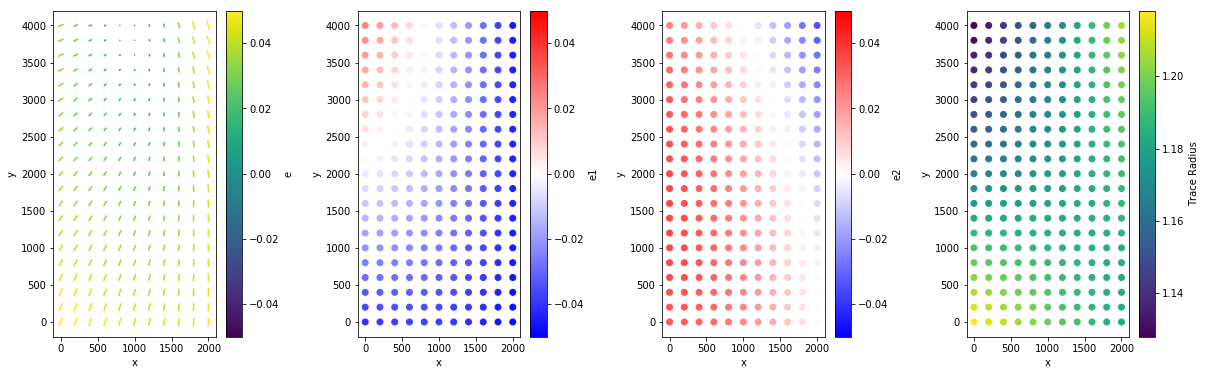

In [137]:
"""
ratio = calexp.getDimensions()[0] / calexp.getDimensions()[1]
print(ratio)
plt.figure(figsize=(1.2  * 6. * ratio, 6.))
#plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(-0.05, 0.05)
plt.xlabel('x')
plt.ylabel('y')

plt.figure(figsize=(1.2  * 6. * ratio, 6.))
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')

plt.figure(figsize=(1.2  * 6. * ratio, 6.))
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
"""

plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 4, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(-0.05, 0.05)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')